In [2]:
import numpy as np
import astropy.io.fits as fits 
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from matplotlib import gridspec
from scipy import ndimage
from scipy.optimize import least_squares

In [3]:
#hdu = fits.open('3C264_DATACUBE.fits')
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
#hdu.info()
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
#[central_x,central_y]= [55,58]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

#print(qso_header)

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                  121 / length of data axis 1                          NAXIS2  =                  121 / length of data axis 2                          NAXIS3  =                 1914 / length of data axis 3                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'DATA    '           / This extension contains data values            HDUCLASS= 'ESO     '           / class name (ESO format)                        HDUDOC  = 'DICD    '           / document with class description                HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      HDUCLAS1= 'IMAGE   '           / Image d

In [6]:
z = 0.02172
k = 1+z
c = 300000
central_vel = c*z

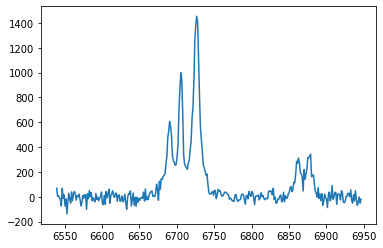

In [11]:
wave = np.arange(wavestart,(wavestart+(wavint*qso_data.shape[0])),wavint)#start,stop,step
wave = wave
select =(wave>6400*k)&(wave<6800*k)
x = wave[select]
y = qso_data[:,57,57][select]
y_err = qso_error[:,57,57][select]
plt.plot(x,y)
plt.show()

In [12]:
def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Ha_gauss(wave,amp_Ha,vel,vel_sigma):
    Ha = gauss(wave,amp_Ha,vel,vel_sigma,6562.85)
    return Ha

def Hb_O3_gauss(wave,amp_Hb,amp_OIII5007,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    OIII_4959 = (0.33)*gauss(wave,amp_OIII5007,vel,vel_sigma,4958.9)
    OIII_5007 = gauss(wave,amp_OIII5007,vel,vel_sigma,5006.8)
    return Hb + OIII_4959 + OIII_5007

def NII_doublet_gauss(wave,amp_N6583,vel,vel_sigma):
    N_6548 = 0.33*gauss(wave,amp_N6583,vel,vel_sigma,6548.05)
    N_6583 = gauss(wave,amp_N6583,vel,vel_sigma,6583.45)
    return N_6548+N_6583

def SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel,vel_sigma):
    S_6716 = gauss(wave,amp_S6716,vel,vel_sigma,6716.44)
    S_6731 = gauss(wave,amp_S6731,vel,vel_sigma,6731.82)
    return S_6716+S_6731

def full_gauss(p,wave,data,error):    
    (amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,vel_core,vel_core_sigma,vel_wing, vel_wing_sigma,m,c) = p 
    narrow_Ha = Ha_gauss(wave,amp_Ha,vel_core,vel_core_sigma)
    broad_Ha = Ha_gauss(wave,amp_Ha_br,vel_wing,vel_wing_sigma)
    narrow_NII = NII_doublet_gauss(wave,amp_N6583,vel_core,vel_core_sigma)
    broad_NII = NII_doublet_gauss(wave,amp_N6583_br,vel_wing,vel_wing_sigma)
    narrow_SII = SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel_core,vel_core_sigma)
    broad_SII = SII_doublet_gauss(wave,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma)
    cont = (wave/1000.0)*m+c
    return (narrow_Ha+broad_Ha+narrow_NII+broad_NII+narrow_SII+broad_SII+cont-data)/error

In [13]:
lower_bounds = [0,0,0,0,0,0,0,0,central_vel - 1000,0,central_vel - 1000,0,-np.inf,-np.inf]
upper_bounds = [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,central_vel + 1000,200,central_vel + 1000,600,np.inf,np.inf]
bounds_p_init = (lower_bounds,upper_bounds) 
        
result = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],bounds=bounds_p_init,args = (x,y,y_err),max_nfev=10000000)
popt = result['x']

#popt,pcov1 = leastsq(full_gauss,x0=[850,80,856,640,195,87,176,140,6,103,11,340,-3,18],args = (x,y,y_err),maxfev=10000000)

print(popt)
[amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c] = popt

[ 806.15061221  133.32989491  893.4559503   649.35098702  194.52039811
   93.86525071  178.22453511  132.59300122 6511.82921461  103.01637393
 6501.11964805  340.94087998  -12.83683046   87.52263143]


Text(0, 0.5, 'Residuals')

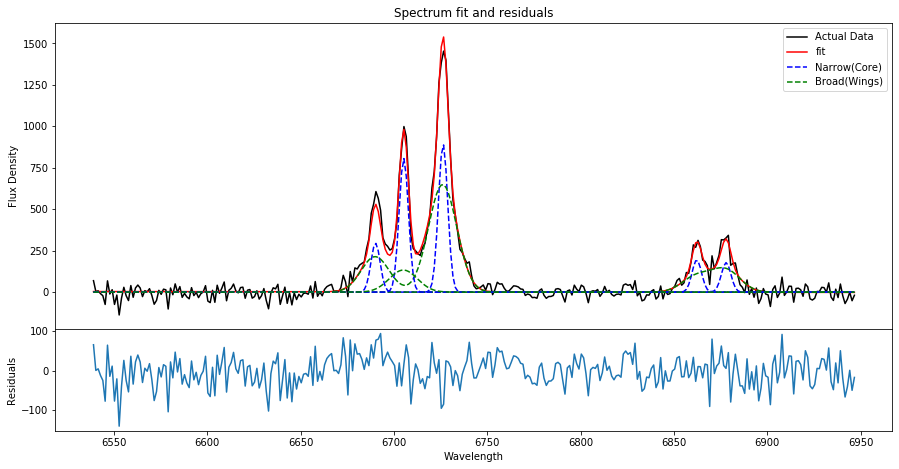

In [15]:
fit = full_gauss(popt,x,y,y_err)*(y_err)+y
residual = y - fit

plt.figure(figsize=(15,7.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # # set height ratios for sublots

ax1=plt.subplot(gs[0])  # first subplot
ax1.plot(x,y,'-k',label='Actual Data')
ax1.plot(x,fit,'-r',label='fit')

plt.plot(x,NII_doublet_gauss(x,amp_N6583,vel_core,vel_core_sigma),'--b')#,label='NII6583')
plt.plot(x,NII_doublet_gauss(x,amp_N6583_br,vel_wing,vel_wing_sigma),'--g')#,label='NII6583_br')
plt.plot(x,SII_doublet_gauss(x,amp_S6716,amp_S6731,vel_core,vel_core_sigma),'--b',label = 'Narrow(Core)')
plt.plot(x,SII_doublet_gauss(x,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma),'--g',label='Broad(Wings)')
plt.plot(x,Ha_gauss(x,amp_Ha,vel_core,vel_core_sigma),'--b')
plt.plot(x,Ha_gauss(x,amp_Ha_br,vel_wing,vel_wing_sigma),'--g')

plt.title('Spectrum fit and residuals')
plt.ylabel('Flux Density')
plt.legend()

ax2=plt.subplot(gs[1])  # second subplot
plt.plot(x,residual)
plt.subplots_adjust(hspace=0)
plt.xlabel('Wavelength')
plt.ylabel('Residuals')